In [1]:
from argparse import ArgumentParser
from os.path import join

import csiborgtools
import healpy
import matplotlib.pyplot as plt
import numpy
import scienceplots  # noqa
from cache_to_disk import cache_to_disk, delete_disk_caches_for_function

import plt_utils

In [12]:
from h5py import File

In [33]:
with File("/mnt/extraspace/rstiskalek/csiborg2_main/fields/chain_15517_1024.hdf5", 'r') as f:
    # density = f['density'][:]
    px = f['p0'][:]

In [17]:
density /= density.mean()
density += 1

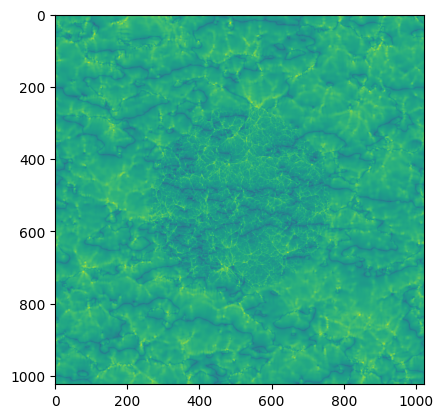

In [38]:
k = 512
plt.figure()
# plt.imshow(numpy.log10(density[:, k, :]))
plt.imshow(numpy.log10(numpy.abs(px[:, k, :])))

# plt.savefig("../plots/density.png", dpi=1500)
plt.show()

# Sky distribution

In [2]:
theta, phi = healpy.pix2ang(12, numpy.arange(healpy.nside2npix(12)))

In [3]:
d = numpy.genfromtxt("/mnt/zfsusers/rstiskalek/csiborgtools/data/2MPP.txt")

In [4]:
# delete_disk_caches_for_function("_plot_sky_projected_density")

@cache_to_disk(30)
def _plot_sky_projected_density(nsim, simname, grid, nside, MAS="PCS",
                                dmin=0, dmax=220, volume_weight=True):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    nsnap = max(paths.get_snapshots(nsim, simname))
    # Some work here to get the box
    box = csiborgtools.read.CSiBORG1Box(nsnap, nsim, paths)

    field = numpy.load(paths.field("density", MAS, grid, nsim, in_rsp=False))

    field /= numpy.mean(field)
    field += 1

    angpos = csiborgtools.field.nside2radec(nside)
    dist = numpy.linspace(dmin, dmax, 1000)
    return csiborgtools.field.make_sky(field, angpos=angpos, dist=dist,
                                       box=box, volume_weight=volume_weight)

In [9]:
def plot_sky_projected_density(nsim, simname, grid, nside, MAS="PCS",
                               dmin=0, dmax=220, volume_weight=True, ext="png",
                               to_save=False):
    dmap = _plot_sky_projected_density(nsim, simname, grid, nside, MAS,
                                           dmin, dmax, volume_weight)
    obs = numpy.genfromtxt("/mnt/zfsusers/rstiskalek/csiborgtools/data/2MPP.txt")
    
    dist = obs[:, 6] * 3e5 / 100
    
    mask = (dist > dmin) & (dist < dmax)
    obs = obs[mask]

    print(obs[:, 2].min(), obs[:, 2].max())

    with plt.style.context(plt_utils.mplstyle):
        healpy.mollview(numpy.log10(dmap), fig=0, title="", unit="", rot=90)

        # healpy.projscatter(numpy.pi / 2 - obs[:, 2], obs[:, 1], s=1, c="red",
        #                    label="2M++ galaxies")
        healpy.projscatter(obs[:, 2] - numpy.pi / 2, obs[:, 1], s=1, c="red",
                           label="2M++ galaxies")
        # healpy.projscatter(obs[:, 2] - numpy.pi / 2 , obs[:, 1], s=1, c="red",
                        #    label="2M++ galaxies")

        # if plot_groups:
        #     groups = csiborgtools.read.TwoMPPGroups(fpath="/mnt/extraspace/rstiskalek/catalogs/2M++_group_catalog.dat")  # noqa
        #     healpy.projscatter(numpy.deg2rad(groups["DEC"] + 90),
        #                        numpy.deg2rad(groups["RA"]), s=1, c="blue",
        #                        label="2M++ groups")

        # if plot_halos is not None or plot_groups:
        #     plt.legend(markerscale=5)

        if to_save:
            fout = join(plt_utils.fout, f"sky_density_{simname}_{nsim}_from_{dmin}_to_{dmax}_vol{volume_weight}.{ext}")  # noqa
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
        plt.show()

-1.50771 1.55388


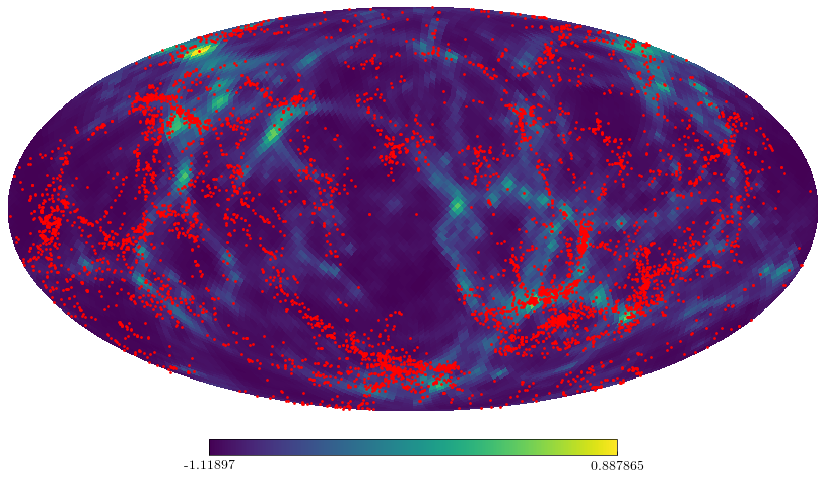

In [10]:
plot_sky_projected_density(7444, "csiborg", 512, 32, "PCS", dmin=30,
                           dmax=50, volume_weight=True)